In [21]:
# 셀 1: 라이브러리 및 데이터 로드

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

import matplotlib.pyplot as plt

# 경로는 너가 사용하는 경로로 변경
path = "/content/drive/MyDrive/Colab Notebooks/cohort_ver151_129_183_merged_ordered.csv"

df = pd.read_csv(path)

print("[INFO] 데이터 shape:", df.shape)
print("[INFO] 컬럼 목록:")
print(df.columns.tolist())


[INFO] 데이터 shape: (40817, 38)
[INFO] 컬럼 목록:
['subject_id', 'hadm_id', 'age', 'gender', 'race', 'arrival_transport', 'cci_score', 'hfrs_score', 'door_to_ecg', 'door_to_trop', 'door_to_anti', 'door_to_pci', 'door_to_ecg_missing_flag', 'door_to_trop_missing_flag', 'door_to_anti_missing_flag', 'door_to_pci_missing_flag', 'prefix_len', 'current_event_id', 'time_since_start_min', 'time_since_ed', 'time_since_last', 'is_night', 'cum_ecg_cnt', 'cum_stemi_cnt', 'cum_trop_cnt', 'stemi_flag', 'trop_pos_flag', 'last_trop', 'run_max_trop', 'trop_trend', 'pci_status', 'current_heart_rate', 'current_mean_bp', 'timestamp', 'target_mortality', 'target_next_evt', 'target_time_to_next', 'target_remain_los']


In [22]:
# 셀 2: 타깃 분포 확인

y = df["target_mortality"]

print("[INFO] target_mortality 분포:")
print(y.value_counts())
print("\n비율:")
print(y.value_counts(normalize=True))


[INFO] target_mortality 분포:
target_mortality
0    37238
1     3579
Name: count, dtype: int64

비율:
target_mortality
0    0.912316
1    0.087684
Name: proportion, dtype: float64


In [23]:
# 셀 3: race 그룹화

def map_race_to_group(x: str) -> str:
    """
    MIMIC race를 6개 그룹으로 매핑:
    WHITE, BLACK, ASIAN, LATINO, OTHER, UNKNOWN
    """
    if pd.isna(x):
        return "UNKNOWN"
    s = str(x).upper().strip()

    # 1) UNKNOWN 계열
    if s in ["UNKNOWN", "UNABLE TO OBTAIN", "PATIENT DECLINED TO ANSWER"]:
        return "UNKNOWN"

    # 2) ASIAN 계열
    if s.startswith("ASIAN"):
        return "ASIAN"

    # 3) BLACK 계열
    if s.startswith("BLACK"):
        return "BLACK"

    # 4) HISPANIC / LATINO 계열
    if "HISPANIC" in s or "LATINO" in s:
        return "LATINO"

    # 5) WHITE 계열 (포르투갈/브라질 포함)
    if s.startswith("WHITE") or s == "PORTUGUESE":
        return "WHITE"

    # 6) 그 외 모두 OTHER
    return "OTHER"

df["race_grouped"] = df["race"].apply(map_race_to_group)

print("[INFO] race_grouped 분포:")
print(df["race_grouped"].value_counts())


[INFO] race_grouped 분포:
race_grouped
WHITE      24559
BLACK       6702
UNKNOWN     3305
LATINO      2316
OTHER       2200
ASIAN       1735
Name: count, dtype: int64


In [24]:
# 셀 4: 원-핫 인코딩

df_enc = df.copy()

# arrival_transport를 문자열로 캐스팅하면 get_dummies가 보기 좋게 나옴
df_enc["arrival_transport"] = df_enc["arrival_transport"].astype("int").astype("category")

cat_cols = ["race_grouped", "arrival_transport"]

df_enc = pd.get_dummies(
    df_enc,
    columns=cat_cols,
    drop_first=False,     # one-hot 풀로 유지 (해석용)
    prefix=cat_cols
)

print("[INFO] 인코딩 후 컬럼 수:", len(df_enc.columns))
df_enc.head(3)


[INFO] 인코딩 후 컬럼 수: 47


,subject_id,hadm_id,age,gender,race,cci_score,hfrs_score,door_to_ecg,door_to_trop,door_to_anti,...,race_grouped_ASIAN,race_grouped_BLACK,race_grouped_LATINO,race_grouped_OTHER,race_grouped_UNKNOWN,race_grouped_WHITE,arrival_transport_0,arrival_transport_1,arrival_transport_2,arrival_transport_3
0,13647833,20006266,40,1,ASIAN - SOUTH EAST ASIAN,0,0.0,-1.0,626.0,-1.0,...,True,False,False,False,False,False,False,True,False,False
1,13647833,20006266,40,1,ASIAN - SOUTH EAST ASIAN,0,0.0,-1.0,626.0,-1.0,...,True,False,False,False,False,False,False,True,False,False
2,13647833,20006266,40,1,ASIAN - SOUTH EAST ASIAN,0,0.0,-1.0,626.0,-1.0,...,True,False,False,False,False,False,False,True,False,False


In [25]:
# 셀 5: X / y 분리

TARGET_COL = "target_mortality"

# 모델에 넣지 않을 컬럼들
drop_cols = [
    "subject_id",
    "hadm_id",
    "timestamp",
    "race",           # raw race (그룹화 전)
    "race_grouped",   # 원-핫으로 대체됨
    "target_mortality",
    "target_next_evt",
    "target_time_to_next",
    "target_remain_los"
]

feature_cols = [c for c in df_enc.columns if c not in drop_cols]

X = df_enc[feature_cols].copy()
y = df_enc[TARGET_COL].copy()

print("[INFO] 최종 사용 피처 수:", len(feature_cols))
print(feature_cols[:20])  # 앞 일부만 확인


[INFO] 최종 사용 피처 수: 39
['age', 'gender', 'cci_score', 'hfrs_score', 'door_to_ecg', 'door_to_trop', 'door_to_anti', 'door_to_pci', 'door_to_ecg_missing_flag', 'door_to_trop_missing_flag', 'door_to_anti_missing_flag', 'door_to_pci_missing_flag', 'prefix_len', 'current_event_id', 'time_since_start_min', 'time_since_ed', 'time_since_last', 'is_night', 'cum_ecg_cnt', 'cum_stemi_cnt']


In [26]:
# 셀 6: hadm_id 단위 train/test split

from sklearn.utils import shuffle

unique_hadm = df_enc["hadm_id"].unique()
print("[INFO] 전체 hadm_id 수:", len(unique_hadm))

train_hadm, test_hadm = train_test_split(
    unique_hadm,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print("[INFO] train hadm 개수:", len(train_hadm))
print("[INFO] test  hadm 개수:", len(test_hadm))

# hadm_id 기준으로 마스크 생성
train_mask = df_enc["hadm_id"].isin(train_hadm)
test_mask  = df_enc["hadm_id"].isin(test_hadm)

X_train = X[train_mask].reset_index(drop=True)
X_test  = X[test_mask].reset_index(drop=True)
y_train = y[train_mask].reset_index(drop=True)
y_test  = y[test_mask].reset_index(drop=True)

print("[INFO] X_train shape:", X_train.shape)
print("[INFO] X_test  shape:", X_test.shape)
print("[INFO] y_train 분포:")
print(y_train.value_counts(normalize=True))
print("[INFO] y_test  분포:")
print(y_test.value_counts(normalize=True))


[INFO] 전체 hadm_id 수: 1929
[INFO] train hadm 개수: 1543
[INFO] test  hadm 개수: 386
[INFO] X_train shape: (32465, 39)
[INFO] X_test  shape: (8352, 39)
[INFO] y_train 분포:
target_mortality
0    0.915571
1    0.084429
Name: proportion, dtype: float64
[INFO] y_test  분포:
target_mortality
0    0.899665
1    0.100335
Name: proportion, dtype: float64


In [27]:
# 셀 7: 스케일링 + 모델 학습

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

log_reg = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train_scaled, y_train)

print("[INFO] 학습 완료")


[INFO] 학습 완료


=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9688    0.7397    0.8389      7514
           1     0.2520    0.7864    0.3817       838

    accuracy                         0.7444      8352
   macro avg     0.6104    0.7630    0.6103      8352
weighted avg     0.8969    0.7444    0.7930      8352

=== Confusion Matrix ===
[[5558 1956]
 [ 179  659]]
ROC-AUC: 0.8473


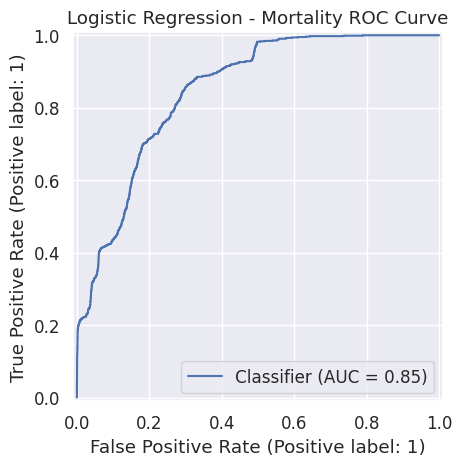

In [28]:
# 셀 8: 예측 및 평가

y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # class 1 확률

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {auc:.4f}")

# ROC Curve 시각화
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Logistic Regression - Mortality ROC Curve")
plt.show()


In [29]:
# 셀 9: 계수(Feature importance) 해석

coef = log_reg.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coef": coef
})

coef_df["abs_coef"] = coef_df["coef"].abs()
coef_df_sorted = coef_df.sort_values("abs_coef", ascending=False)

print("=== 계수 상위 20개 (절대값 기준) ===")
coef_df_sorted.head(20)


=== 계수 상위 20개 (절대값 기준) ===


,feature,coef,abs_coef
12,prefix_len,-1.833614,1.833614
18,cum_ecg_cnt,1.578218,1.578218
11,door_to_pci_missing_flag,-1.022509,1.022509
0,age,0.901392,0.901392
28,current_mean_bp,-0.355423,0.355423
26,pci_status,-0.321550,0.321550
3,hfrs_score,0.291035,0.291035
2,cci_score,0.273307,0.273307
20,cum_trop_cnt,0.263850,0.263850
33,race_grouped_UNKNOWN,0.227828,0.227828
